In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
gpu = 5
multi_gpus = None #[0, 1, 2]
b = 8
zero_one_normalize = False
dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
table = "/analysis/ritter/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [9]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [10]:
# shuffle the dataset
df = df.sample(frac=0.2, random_state=23)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [11]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [12]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [13]:
intensity = IntensityRescale(masked=False)
input_trans = transforms.Compose(augmentations + [intensity, ToTensor()])

In [14]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)

In [15]:
len(ukb_data)

371

In [16]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]

In [17]:
sample = ukb_data[3]
img = sample["image"]

In [18]:
img.shape

torch.Size([1, 182, 218, 182])

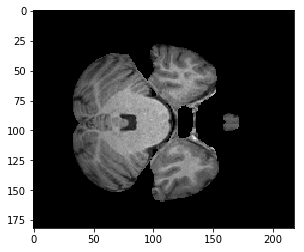

In [19]:
plt.imshow(img[0][:,:,40], cmap='gray')

In [20]:
sample["label"]

tensor([1.])

# Define the classifier

In [21]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        self.Conv_5 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_5 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(11200, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_5(x)) 
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [23]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [24]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 1303769


# Training

In [25]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-4
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

         # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=20,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [26]:
num_epochs = 200
min_iters = 3
ignore_epochs = 30
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [27]:
r = 4

In [28]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/20_percent/baseline/"
callbacks = [EarlyStopping(patience=10, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
[0,    20] loss: 0.69505
Time elapsed: 0h:0m:23s
train accuracy_score: 50.84 %
train balanced_accuracy: 48.38 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.762343
[1,    20] loss: 0.68972
Time elapsed: 0h:0m:58s
train accuracy_score: 53.36 %
train balanced_accuracy: 49.22 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.713590
[2,    20] loss: 0.69789
Time elapsed: 0h:1m:34s
train accuracy_score: 51.68 %
train balanced_accuracy: 47.74 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695166
[3,    20] loss: 0.70132
Time elapsed: 0h:2m:9s
train accuracy_score: 54.62 %
train balanced_accuracy: 48.95 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700062
[4,    20] loss: 0.68738
Time elapsed: 0h:2m:45s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.37 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.707849
[5,    20] loss: 0.69163
Time elap

[43,    20] loss: 0.69303
Time elapsed: 0h:26m:1s
train accuracy_score: 57.56 %
train balanced_accuracy: 51.32 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.717061
[44,    20] loss: 0.67778
Time elapsed: 0h:26m:36s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.49 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.692174
[45,    20] loss: 0.67854
Time elapsed: 0h:27m:13s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.35 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.687676
[46,    20] loss: 0.67428
Time elapsed: 0h:27m:48s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.26 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.692258
[47,    20] loss: 0.67981
Time elapsed: 0h:28m:23s
train accuracy_score: 53.36 %
train balanced_accuracy: 47.50 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.692893
[48,    20] loss: 0.66885
Time elapsed: 0

[86,    20] loss: 0.42372
Time elapsed: 0h:51m:20s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.57 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.53 %
Val loss: 0.355809
[87,    20] loss: 0.47480
Time elapsed: 0h:51m:57s
train accuracy_score: 81.51 %
train balanced_accuracy: 80.71 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.21 %
Val loss: 0.528642
[88,    20] loss: 0.50756
Time elapsed: 0h:52m:32s
train accuracy_score: 77.31 %
train balanced_accuracy: 77.24 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.47 %
Val loss: 0.413151
[89,    20] loss: 0.43575
Time elapsed: 0h:53m:7s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.11 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.66 %
Val loss: 0.362951
[90,    20] loss: 0.37278
Time elapsed: 0h:53m:42s
train accuracy_score: 80.25 %
train balanced_accuracy: 79.14 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.32 %
Val loss: 0.375856
[91,    20] loss: 0.38091
Time elapsed: 0

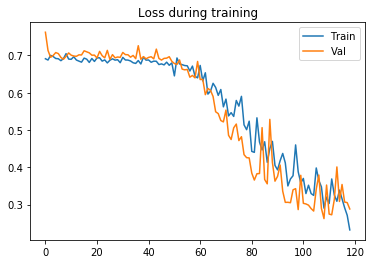

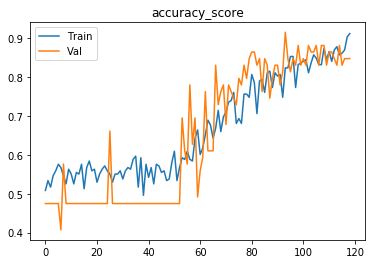

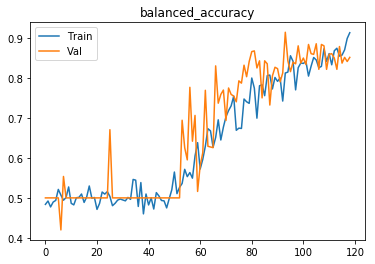

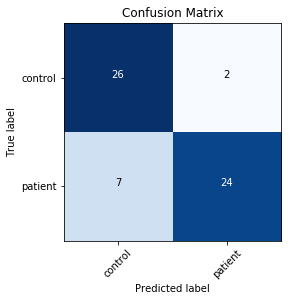

Starting trial 1
[0,    20] loss: 0.70845
Time elapsed: 0h:0m:24s
train accuracy_score: 56.30 %
train balanced_accuracy: 51.24 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.706494
[1,    20] loss: 0.67483
Time elapsed: 0h:1m:0s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.41 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.690723
[2,    20] loss: 0.69768
Time elapsed: 0h:1m:35s
train accuracy_score: 52.52 %
train balanced_accuracy: 48.02 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.694756
[3,    20] loss: 0.68838
Time elapsed: 0h:2m:13s
train accuracy_score: 52.10 %
train balanced_accuracy: 49.49 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.697994
[4,    20] loss: 0.67598
Time elapsed: 0h:2m:48s
train accuracy_score: 57.98 %
train balanced_accuracy: 52.38 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.699290
[5,    20] loss: 0.68921
Time elap

[43,    20] loss: 0.68108
Time elapsed: 0h:25m:39s
train accuracy_score: 55.88 %
train balanced_accuracy: 52.37 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.683160
[44,    20] loss: 0.66604
Time elapsed: 0h:26m:15s
train accuracy_score: 59.66 %
train balanced_accuracy: 53.74 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.676826
[45,    20] loss: 0.66901
Time elapsed: 0h:26m:51s
train accuracy_score: 55.88 %
train balanced_accuracy: 51.79 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696563
[46,    20] loss: 0.66978
Time elapsed: 0h:27m:26s
train accuracy_score: 56.30 %
train balanced_accuracy: 51.24 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.61 %
Val loss: 0.677923
[47,    20] loss: 0.66074
Time elapsed: 0h:28m:0s
train accuracy_score: 60.92 %
train balanced_accuracy: 56.12 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.660845
[48,    20] loss: 0.64805
Time elapsed: 0

[86,    20] loss: 0.33378
Time elapsed: 0h:51m:2s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.60 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.07 %
Val loss: 0.386162
[87,    20] loss: 0.36451
Time elapsed: 0h:51m:36s
train accuracy_score: 87.39 %
train balanced_accuracy: 86.59 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.07 %
Val loss: 0.378284
[88,    20] loss: 0.40543
Time elapsed: 0h:52m:12s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.58 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.30 %
Val loss: 0.367423
[89,    20] loss: 0.34017
Time elapsed: 0h:52m:47s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.02 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.46 %
Val loss: 0.376094
[90,    20] loss: 0.31090
Time elapsed: 0h:53m:21s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.42 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.19 %
Val loss: 0.301163
[91,    20] loss: 0.27071
Time elapsed: 0

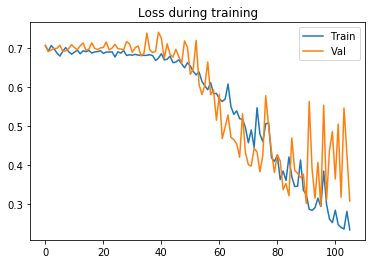

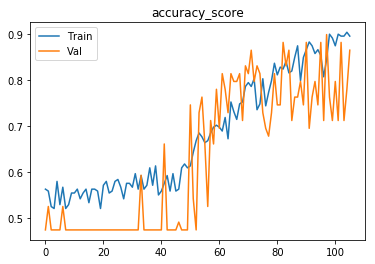

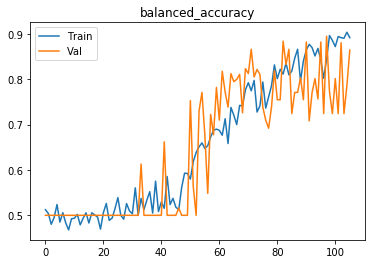

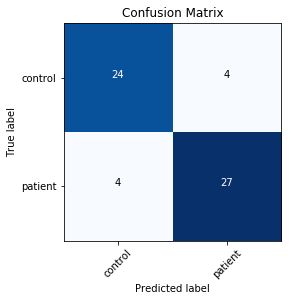

Starting trial 2
[0,    20] loss: 0.69952
Time elapsed: 0h:0m:24s
train accuracy_score: 55.04 %
train balanced_accuracy: 48.75 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703863
[1,    20] loss: 0.69569
Time elapsed: 0h:0m:58s
train accuracy_score: 54.62 %
train balanced_accuracy: 48.26 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695505
[2,    20] loss: 0.69302
Time elapsed: 0h:1m:33s
train accuracy_score: 54.62 %
train balanced_accuracy: 49.64 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.704330
[3,    20] loss: 0.68903
Time elapsed: 0h:2m:7s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.49 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.704143
[4,    20] loss: 0.69585
Time elapsed: 0h:2m:42s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.49 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700633
[5,    20] loss: 0.70886
Time elap

[43,    20] loss: 0.67400
Time elapsed: 0h:25m:6s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.691497
[44,    20] loss: 0.68621
Time elapsed: 0h:25m:40s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.23 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702992
[45,    20] loss: 0.67291
Time elapsed: 0h:26m:15s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.60 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.693419
[46,    20] loss: 0.68041
Time elapsed: 0h:26m:50s
train accuracy_score: 56.72 %
train balanced_accuracy: 52.19 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696945
[47,    20] loss: 0.67710
Time elapsed: 0h:27m:26s
train accuracy_score: 59.24 %
train balanced_accuracy: 53.14 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.699142
[48,    20] loss: 0.67494
Time elapsed: 0

[86,    20] loss: 0.31569
Time elapsed: 0h:50m:5s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.22 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.63 %
Val loss: 0.413523
[87,    20] loss: 0.37032
Time elapsed: 0h:50m:38s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.88 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.25 %
Val loss: 0.412255
[88,    20] loss: 0.31416
Time elapsed: 0h:51m:12s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.37 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.03 %
Val loss: 0.281926
[89,    20] loss: 0.37314
Time elapsed: 0h:51m:46s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.54 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.09 %
Val loss: 0.385618
[90,    20] loss: 0.31819
Time elapsed: 0h:52m:21s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.88 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.89 %
Val loss: 0.332551
[91,    20] loss: 0.27990
Time elapsed: 0

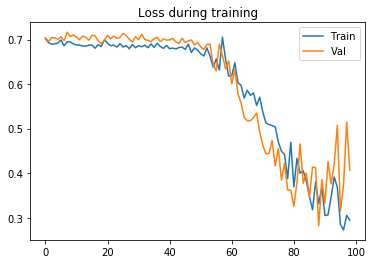

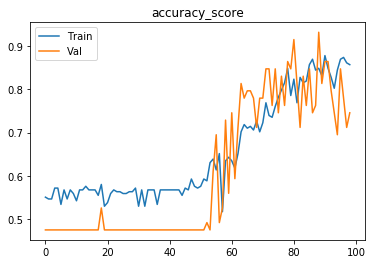

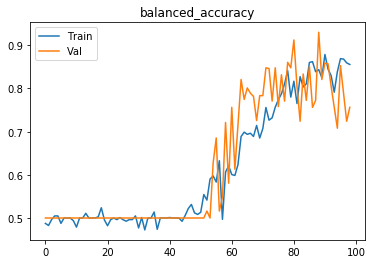

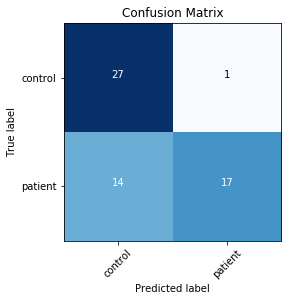

Starting trial 3
[0,    20] loss: 0.70199
Time elapsed: 0h:0m:24s
train accuracy_score: 52.52 %
train balanced_accuracy: 46.99 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.708905
[1,    20] loss: 0.69902
Time elapsed: 0h:1m:0s
train accuracy_score: 53.78 %
train balanced_accuracy: 48.67 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.693589
[2,    20] loss: 0.69143
Time elapsed: 0h:1m:34s
train accuracy_score: 53.78 %
train balanced_accuracy: 48.10 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.715316
[3,    20] loss: 0.70175
Time elapsed: 0h:2m:7s
train accuracy_score: 52.52 %
train balanced_accuracy: 46.76 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.723613
[4,    20] loss: 0.69444
Time elapsed: 0h:2m:44s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.60 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702978
[5,    20] loss: 0.68163
Time elaps

[43,    20] loss: 0.66414
Time elapsed: 0h:25m:34s
train accuracy_score: 60.50 %
train balanced_accuracy: 56.67 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.04 %
Val loss: 0.638871
[44,    20] loss: 0.64277
Time elapsed: 0h:26m:11s
train accuracy_score: 57.98 %
train balanced_accuracy: 54.22 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.51 %
Val loss: 0.626403
[45,    20] loss: 0.63264
Time elapsed: 0h:26m:46s
train accuracy_score: 62.18 %
train balanced_accuracy: 60.57 %
val accuracy_score: 64.41 %
val balanced_accuracy: 62.85 %
Val loss: 0.626833
[46,    20] loss: 0.68176
Time elapsed: 0h:27m:20s
train accuracy_score: 64.71 %
train balanced_accuracy: 63.60 %
val accuracy_score: 49.15 %
val balanced_accuracy: 51.61 %
Val loss: 0.663717
[47,    20] loss: 0.66603
Time elapsed: 0h:27m:55s
train accuracy_score: 63.45 %
train balanced_accuracy: 60.30 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.74 %
Val loss: 0.615057
[48,    20] loss: 0.64312
Time elapsed: 

[86,    20] loss: 0.41521
Time elapsed: 0h:50m:43s
train accuracy_score: 78.57 %
train balanced_accuracy: 77.43 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.74 %
Val loss: 0.430767
[87,    20] loss: 0.42223
Time elapsed: 0h:51m:18s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.18 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.25 %
Val loss: 0.477527
[88,    20] loss: 0.31797
Time elapsed: 0h:51m:53s
train accuracy_score: 86.97 %
train balanced_accuracy: 85.99 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.74 %
Val loss: 0.355200
[89,    20] loss: 0.35912
Time elapsed: 0h:52m:28s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.00 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.97 %
Val loss: 0.356822
[90,    20] loss: 0.40767
Time elapsed: 0h:53m:4s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.00 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.30 %
Val loss: 0.395140
[91,    20] loss: 0.37548
Time elapsed: 0

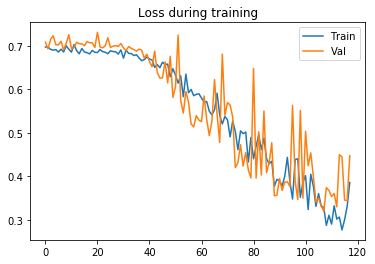

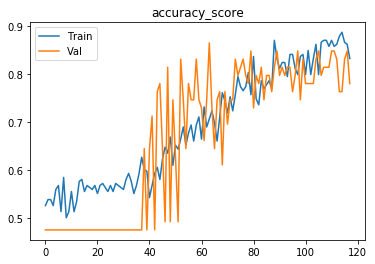

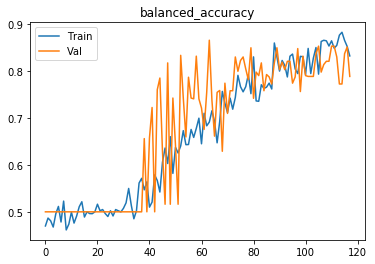

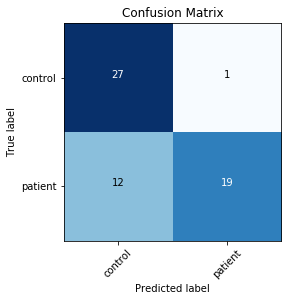

Starting trial 4
[0,    20] loss: 0.70679
Time elapsed: 0h:0m:24s
train accuracy_score: 48.74 %
train balanced_accuracy: 44.69 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.694624
[1,    20] loss: 0.69667
Time elapsed: 0h:0m:59s
train accuracy_score: 55.04 %
train balanced_accuracy: 49.55 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.709173
[2,    20] loss: 0.67381
Time elapsed: 0h:1m:34s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.41 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.690423
[3,    20] loss: 0.68800
Time elapsed: 0h:2m:10s
train accuracy_score: 55.88 %
train balanced_accuracy: 54.78 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.737658
[4,    20] loss: 0.70757
Time elapsed: 0h:2m:44s
train accuracy_score: 52.52 %
train balanced_accuracy: 51.01 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.723732
[5,    20] loss: 0.68301
Time ela

[43,    20] loss: 0.68751
Time elapsed: 0h:26m:0s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.99 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.690806
[44,    20] loss: 0.66779
Time elapsed: 0h:26m:35s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.35 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.684293
[45,    20] loss: 0.68208
Time elapsed: 0h:27m:10s
train accuracy_score: 57.98 %
train balanced_accuracy: 55.02 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703102
[46,    20] loss: 0.66764
Time elapsed: 0h:27m:45s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.90 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.23 %
Val loss: 0.679060
[47,    20] loss: 0.67624
Time elapsed: 0h:28m:21s
train accuracy_score: 60.50 %
train balanced_accuracy: 56.56 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.683360
[48,    20] loss: 0.65952
Time elapsed: 0

[86,    20] loss: 0.55981
Time elapsed: 0h:51m:21s
train accuracy_score: 73.95 %
train balanced_accuracy: 72.89 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.81 %
Val loss: 0.579927
[87,    20] loss: 0.51619
Time elapsed: 0h:51m:56s
train accuracy_score: 75.21 %
train balanced_accuracy: 73.78 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.42 %
Val loss: 0.477017
[88,    20] loss: 0.49948
Time elapsed: 0h:52m:35s
train accuracy_score: 78.15 %
train balanced_accuracy: 77.29 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.69 %
Val loss: 0.452356
[89,    20] loss: 0.49563
Time elapsed: 0h:53m:9s
train accuracy_score: 76.89 %
train balanced_accuracy: 75.60 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.66 %
Val loss: 0.392118
[90,    20] loss: 0.47740
Time elapsed: 0h:53m:44s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.60 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.70 %
Val loss: 0.402251
[91,    20] loss: 0.46512
Time elapsed: 0

[129,    20] loss: 0.23303
Time elapsed: 1h:16m:48s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.53 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.41 %
Val loss: 0.267101
Early stopping in epoch 130
Total time elapsed: 1h:17m:1s
Writing model to disk...
Best result during training: 0.90. Saving model..
Finished fold.


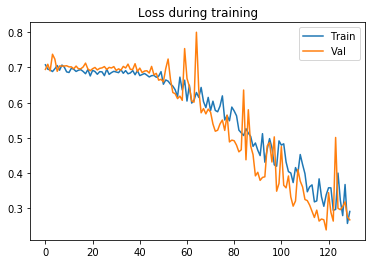

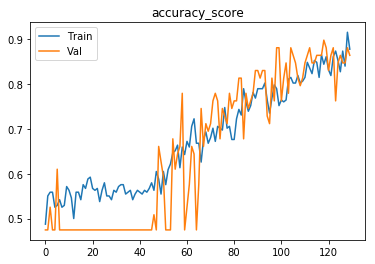

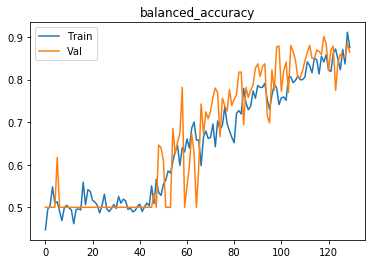

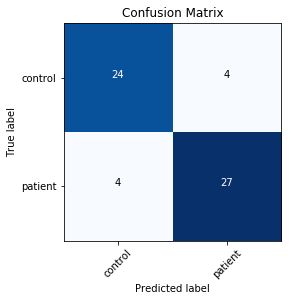

Starting trial 5
[0,    20] loss: 0.69366
Time elapsed: 0h:0m:26s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.58 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.707437
[1,    20] loss: 0.69049
Time elapsed: 0h:1m:2s
train accuracy_score: 54.20 %
train balanced_accuracy: 49.04 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702309
[2,    20] loss: 0.69935
Time elapsed: 0h:1m:36s
train accuracy_score: 53.78 %
train balanced_accuracy: 48.67 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.719769
[3,    20] loss: 0.68218
Time elapsed: 0h:2m:11s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.705076
[4,    20] loss: 0.69767
Time elapsed: 0h:2m:47s
train accuracy_score: 56.30 %
train balanced_accuracy: 51.13 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703899
[5,    20] loss: 0.68436
Time elap

[43,    20] loss: 0.66709
Time elapsed: 0h:25m:32s
train accuracy_score: 62.18 %
train balanced_accuracy: 57.69 %
val accuracy_score: 64.41 %
val balanced_accuracy: 65.78 %
Val loss: 0.649770
[44,    20] loss: 0.65401
Time elapsed: 0h:26m:8s
train accuracy_score: 63.87 %
train balanced_accuracy: 59.98 %
val accuracy_score: 55.93 %
val balanced_accuracy: 57.72 %
Val loss: 0.651219
[45,    20] loss: 0.62277
Time elapsed: 0h:26m:42s
train accuracy_score: 66.81 %
train balanced_accuracy: 63.61 %
val accuracy_score: 67.80 %
val balanced_accuracy: 67.11 %
Val loss: 0.620403
[46,    20] loss: 0.67202
Time elapsed: 0h:27m:16s
train accuracy_score: 64.29 %
train balanced_accuracy: 63.00 %
val accuracy_score: 71.19 %
val balanced_accuracy: 70.68 %
Val loss: 0.615001
[47,    20] loss: 0.63561
Time elapsed: 0h:27m:51s
train accuracy_score: 67.23 %
train balanced_accuracy: 65.47 %
val accuracy_score: 61.02 %
val balanced_accuracy: 62.90 %
Val loss: 0.626827
[48,    20] loss: 0.62584
Time elapsed: 0

[86,    20] loss: 0.33525
Time elapsed: 0h:50m:45s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.34 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.97 %
Val loss: 0.673445
[87,    20] loss: 0.40155
Time elapsed: 0h:51m:20s
train accuracy_score: 80.67 %
train balanced_accuracy: 80.09 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.25 %
Val loss: 0.454801
[88,    20] loss: 0.40880
Time elapsed: 0h:51m:55s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.85 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.35 %
Val loss: 0.314474
[89,    20] loss: 0.28663
Time elapsed: 0h:52m:31s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.51 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.62 %
Val loss: 0.271232
[90,    20] loss: 0.31898
Time elapsed: 0h:53m:6s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.28 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.35 %
Val loss: 0.309985
[91,    20] loss: 0.25955
Time elapsed: 0

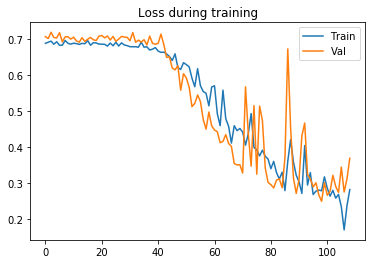

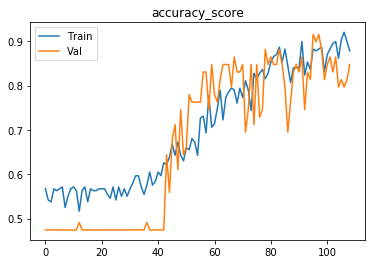

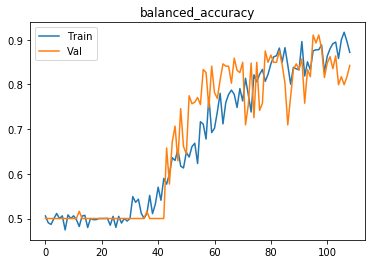

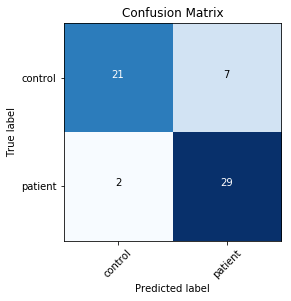

Starting trial 6
[0,    20] loss: 0.72989
Time elapsed: 0h:0m:24s
train accuracy_score: 50.42 %
train balanced_accuracy: 49.28 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.714707
[1,    20] loss: 0.70139
Time elapsed: 0h:1m:0s
train accuracy_score: 51.68 %
train balanced_accuracy: 47.86 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.691469
[2,    20] loss: 0.67412
Time elapsed: 0h:1m:36s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.59 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703699
[3,    20] loss: 0.69085
Time elapsed: 0h:2m:11s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.12 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.694471
[4,    20] loss: 0.67464
Time elapsed: 0h:2m:45s
train accuracy_score: 54.62 %
train balanced_accuracy: 48.38 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.697133
[5,    20] loss: 0.69480
Time elap

[43,    20] loss: 0.68181
Time elapsed: 0h:25m:32s
train accuracy_score: 54.62 %
train balanced_accuracy: 49.18 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.695181
[44,    20] loss: 0.65889
Time elapsed: 0h:26m:8s
train accuracy_score: 57.56 %
train balanced_accuracy: 51.43 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.686223
[45,    20] loss: 0.68479
Time elapsed: 0h:26m:42s
train accuracy_score: 55.88 %
train balanced_accuracy: 51.33 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696706
[46,    20] loss: 0.67232
Time elapsed: 0h:27m:16s
train accuracy_score: 61.76 %
train balanced_accuracy: 58.01 %
val accuracy_score: 54.24 %
val balanced_accuracy: 51.79 %
Val loss: 0.675158
[47,    20] loss: 0.67038
Time elapsed: 0h:27m:53s
train accuracy_score: 61.34 %
train balanced_accuracy: 58.22 %
val accuracy_score: 54.24 %
val balanced_accuracy: 52.13 %
Val loss: 0.691875
[48,    20] loss: 0.69646
Time elapsed: 0

[86,    20] loss: 0.32256
Time elapsed: 0h:50m:46s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.08 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.67 %
Val loss: 0.345954
[87,    20] loss: 0.36959
Time elapsed: 0h:51m:21s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.88 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.07 %
Val loss: 0.393199
[88,    20] loss: 0.40595
Time elapsed: 0h:51m:56s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.98 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.74 %
Val loss: 0.413239
[89,    20] loss: 0.39510
Time elapsed: 0h:52m:30s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.54 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.46 %
Val loss: 0.421418
[90,    20] loss: 0.33969
Time elapsed: 0h:53m:4s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.65 %
val accuracy_score: 71.19 %
val balanced_accuracy: 72.41 %
Val loss: 0.483052
[91,    20] loss: 0.38077
Time elapsed: 0

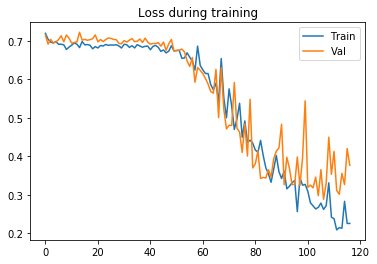

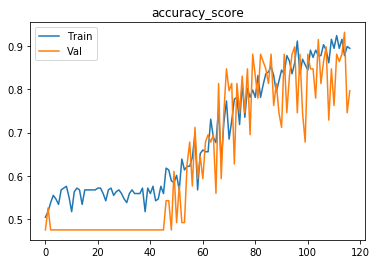

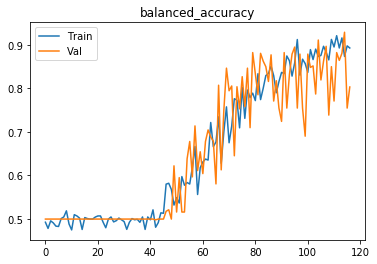

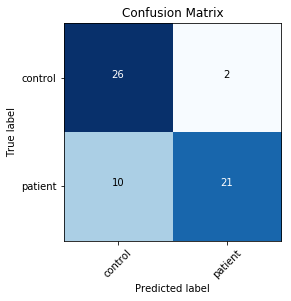

Starting trial 7
[0,    20] loss: 0.69836
Time elapsed: 0h:0m:24s
train accuracy_score: 56.72 %
train balanced_accuracy: 51.50 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.699217
[1,    20] loss: 0.69413
Time elapsed: 0h:0m:58s
train accuracy_score: 56.72 %
train balanced_accuracy: 50.35 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.697278
[2,    20] loss: 0.69199
Time elapsed: 0h:1m:34s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.95 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703747
[3,    20] loss: 0.69308
Time elapsed: 0h:2m:10s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.698759
[4,    20] loss: 0.69965
Time elapsed: 0h:2m:46s
train accuracy_score: 52.10 %
train balanced_accuracy: 48.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.719245
[5,    20] loss: 0.68444
Time ela

[43,    20] loss: 0.69245
Time elapsed: 0h:25m:26s
train accuracy_score: 56.30 %
train balanced_accuracy: 51.82 %
val accuracy_score: 57.63 %
val balanced_accuracy: 59.68 %
Val loss: 0.675970
[44,    20] loss: 0.66931
Time elapsed: 0h:26m:1s
train accuracy_score: 59.24 %
train balanced_accuracy: 53.37 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.690659
[45,    20] loss: 0.66804
Time elapsed: 0h:26m:37s
train accuracy_score: 58.82 %
train balanced_accuracy: 53.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 49.83 %
Val loss: 0.678621
[46,    20] loss: 0.66247
Time elapsed: 0h:27m:12s
train accuracy_score: 61.34 %
train balanced_accuracy: 57.64 %
val accuracy_score: 69.49 %
val balanced_accuracy: 68.72 %
Val loss: 0.655577
[47,    20] loss: 0.63972
Time elapsed: 0h:27m:46s
train accuracy_score: 60.08 %
train balanced_accuracy: 57.68 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.715789
[48,    20] loss: 0.65406
Time elapsed: 0

[86,    20] loss: 0.34919
Time elapsed: 0h:50m:23s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.28 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.24 %
Val loss: 0.351041
[87,    20] loss: 0.35989
Time elapsed: 0h:50m:57s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.28 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.46 %
Val loss: 0.333680
[88,    20] loss: 0.32009
Time elapsed: 0h:51m:31s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.28 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.29 %
Val loss: 0.333335
[89,    20] loss: 0.34014
Time elapsed: 0h:52m:6s
train accuracy_score: 87.39 %
train balanced_accuracy: 86.70 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.29 %
Val loss: 0.309103
[90,    20] loss: 0.39464
Time elapsed: 0h:52m:41s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.45 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.80 %
Val loss: 0.312938
[91,    20] loss: 0.38422
Time elapsed: 0

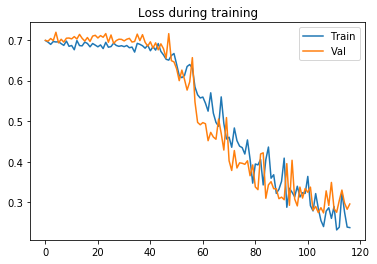

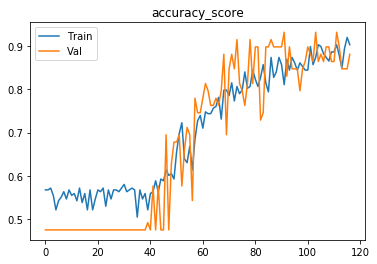

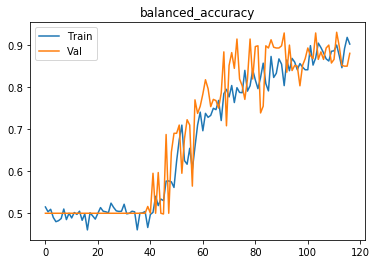

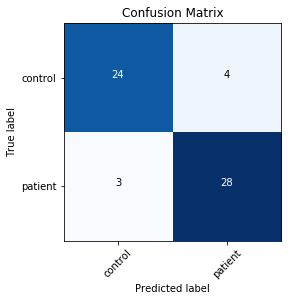

Starting trial 8
[0,    20] loss: 0.68857
Time elapsed: 0h:0m:23s
train accuracy_score: 54.62 %
train balanced_accuracy: 48.49 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.709894
[1,    20] loss: 0.68131
Time elapsed: 0h:0m:58s
train accuracy_score: 52.52 %
train balanced_accuracy: 47.56 %
val accuracy_score: 40.68 %
val balanced_accuracy: 42.34 %
Val loss: 0.695671
[2,    20] loss: 0.68694
Time elapsed: 0h:1m:33s
train accuracy_score: 57.56 %
train balanced_accuracy: 52.81 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.707560
[3,    20] loss: 0.70151
Time elapsed: 0h:2m:7s
train accuracy_score: 56.30 %
train balanced_accuracy: 49.97 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703501
[4,    20] loss: 0.69744
Time elapsed: 0h:2m:40s
train accuracy_score: 53.78 %
train balanced_accuracy: 47.64 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700153
[5,    20] loss: 0.69108
Time elap

[43,    20] loss: 0.68190
Time elapsed: 0h:25m:13s
train accuracy_score: 55.88 %
train balanced_accuracy: 52.14 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702786
[44,    20] loss: 0.63960
Time elapsed: 0h:25m:48s
train accuracy_score: 57.56 %
train balanced_accuracy: 52.81 %
val accuracy_score: 66.10 %
val balanced_accuracy: 64.29 %
Val loss: 0.664150
[45,    20] loss: 0.65433
Time elapsed: 0h:26m:22s
train accuracy_score: 58.40 %
train balanced_accuracy: 54.93 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.661212
[46,    20] loss: 0.65262
Time elapsed: 0h:26m:58s
train accuracy_score: 64.29 %
train balanced_accuracy: 62.54 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.23 %
Val loss: 0.665632
[47,    20] loss: 0.65375
Time elapsed: 0h:27m:33s
train accuracy_score: 59.24 %
train balanced_accuracy: 55.44 %
val accuracy_score: 69.49 %
val balanced_accuracy: 70.79 %
Val loss: 0.651232
[48,    20] loss: 0.63626
Time elapsed: 

[86,    20] loss: 0.30327
Time elapsed: 0h:50m:14s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.45 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.63 %
Val loss: 0.454461
[87,    20] loss: 0.39626
Time elapsed: 0h:50m:48s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.14 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.91 %
Val loss: 0.371806
[88,    20] loss: 0.31982
Time elapsed: 0h:51m:24s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.79 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.50 %
Val loss: 0.361340
[89,    20] loss: 0.30393
Time elapsed: 0h:51m:59s
train accuracy_score: 86.97 %
train balanced_accuracy: 85.99 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.54 %
Val loss: 0.342952
[90,    20] loss: 0.39024
Time elapsed: 0h:52m:34s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.94 %
val accuracy_score: 72.88 %
val balanced_accuracy: 74.02 %
Val loss: 0.462417
[91,    20] loss: 0.30892
Time elapsed: 

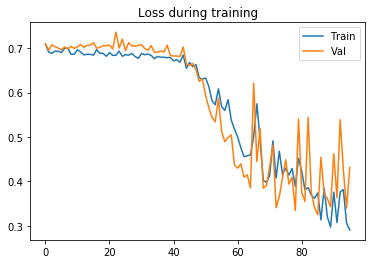

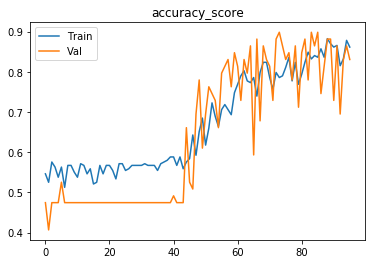

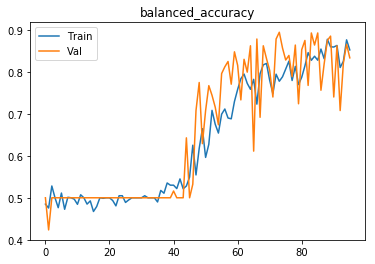

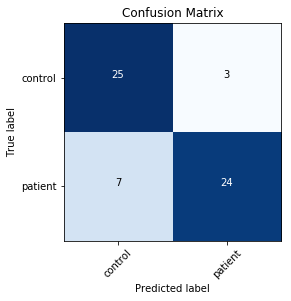

Starting trial 9
[0,    20] loss: 0.68389
Time elapsed: 0h:0m:24s
train accuracy_score: 57.56 %
train balanced_accuracy: 53.73 %
val accuracy_score: 55.93 %
val balanced_accuracy: 57.89 %
Val loss: 0.690089
[1,    20] loss: 0.69742
Time elapsed: 0h:0m:59s
train accuracy_score: 48.74 %
train balanced_accuracy: 45.49 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.725378
[2,    20] loss: 0.72107
Time elapsed: 0h:1m:35s
train accuracy_score: 50.84 %
train balanced_accuracy: 46.20 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.706066
[3,    20] loss: 0.69864
Time elapsed: 0h:2m:10s
train accuracy_score: 52.52 %
train balanced_accuracy: 48.60 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.708190
[4,    20] loss: 0.66251
Time elapsed: 0h:2m:44s
train accuracy_score: 58.82 %
train balanced_accuracy: 54.38 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.691148
[5,    20] loss: 0.68545
Time ela

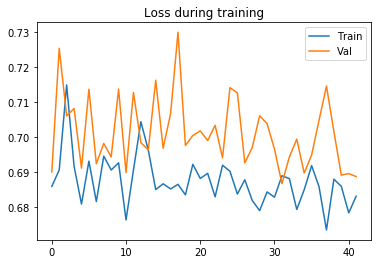

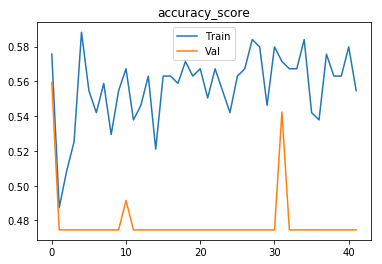

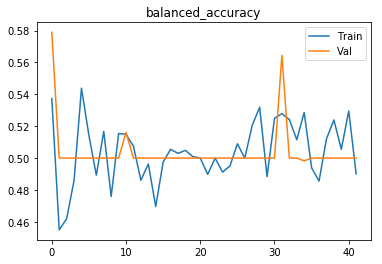

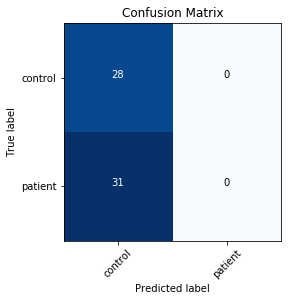

################################
################################
All accuracies: [0.8513824884792627, 0.8640552995391705, 0.756336405529954, 0.788594470046083, 0.8640552995391705, 0.842741935483871, 0.8029953917050692, 0.880184331797235, 0.8335253456221199, 0.5]
Best accuracies mean: 0.874942396313364 All :[0.9141705069124424, 0.8945852534562212, 0.9302995391705069, 0.8657834101382489, 0.9014976958525346, 0.9107142857142857, 0.9285714285714286, 0.9302995391705069, 0.8945852534562212, 0.5789170506912442]
0.7983870967741936
0.10594631906445325


In [29]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [30]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [31]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [32]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [33]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))

Fold 0
0.8457875457875458
Fold 1
0.8146520146520146
Fold 2
0.8644688644688645
Fold 3
0.6989010989010989
Fold 4
0.7886446886446886
Fold 5
0.8945054945054944
Fold 6
0.8545787545787545
Fold 7
0.8787545787545787
Fold 8
0.8758241758241758
Fold 9
0.5029304029304029
######## Final results ########
          0
0  0.845788
1  0.814652
2  0.864469
3  0.698901
4  0.788645
5  0.894505
6  0.854579
7  0.878755
8  0.875824
9  0.502930
Balanced accuracy mean 80.19 %
